# Curve Fitting and $\chi^2$

Here we will study various uses of the $\chi^2$ including the use of `scipy.optimize.curve_fit()` to perform curve fitting and parameter estimation.

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.special as sf
import scipy.linalg as la
#Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

rng = np.random.default_rng()

## Definitions

Recall from lecture that we defined the $\chi^2$ as a measure of the distance between a set of data values, $y_i$ evaluated at points $x_i$ with uncertainties $\sigma_i$ to a model defined in terms a set of parameters $\vec p$ and represented as $f(x,\vec p)$ via
$$ \chi^2 = \sum_{i=1}^n \left( \frac{y_i - f(x_i,\vec p)}{\sigma_i} \right)^2. $$

The value of the $\chi^2$ tells us how close the model is to the data. As a rule of thumb we expect $\chi^2\approx\nu$ where $\nu$ is the number of degrees of freedom. To quantify this we define the goodness of fit, $Q$, as the probability that the $\chi^2$ would be larger than the value we calculate for the number of degrees of freedom we have. (More precisely this is a one sided $p$-value.) This can be calculated in terms of the normalized complement incomplete gamma function,
$$ Q\!\left( \frac{\nu}{2}, \frac{\chi^2}2 \right) = 1 - \frac{\gamma(\nu/2,\chi^2/2)}{\Gamma(\nu/2)}. $$
This can easily be calculated using `scipy.special.gammaincc()`.

### `scipy.stats`

SciPy includes a large module containing a powerful set of tools for performing statistical analyses. We will **not** use that module here; it requires more knowledge of statistical techniques than needed for our uses here. If you choose to use functions from this module make sure you understand what they do!

### Curve Fitting

In `scipy.optimize` there are many, many functions for all forms of minimization and optimization. When we look through the list of functions two stand out, `least_squares` and `curve_fit`. (There is also the "legacy function", `leastsq`, but this should not be used in new code and we will not discuss it.) We should look at these in more detail.

In [ ]:
opt?

In [ ]:
opt.least_squares?

In [ ]:
opt.curve_fit?

It may come as a surprise that `least_squares` is more general routine than `curve_fit`!
In fact, for `least_squares` we need to define a function, the square of which will be minimized.
This function *need not be the $\chi^2$*.
On the other hand `curve_fit` does minimize the $\chi^2$, and will thus be the function we use.

There are many options in `curve_fit`, some of them that will be useful and one that *we must use* whenever we have uncertainties (which we always will have!)
As discussed in the prelab, we **must always use** `absolute_sigma=True`.
I will repeat this many times.

Finally, as noted above the goodness of fit can be calculated using `gammaincc`.

In [ ]:
sf.gammaincc?

## Fit Random Data

Consider the simple function
$$ f(x, a_1, a_2, a_3) = \sin^2(a_1 x) + a_2 \cos^2(a_3 x) $$
where the $a_j$ are parameters. Here we generate random values for $x$ in interval $x\in(0,2)$ and random "data" by including Gaussian fluctuations with variance $\sigma_y$. Since we are generating random values the results for the analysis below can/will change. It is good to run through the analysis a few times with different random data to see how things change.

In [2]:
x = rng.random(size=20) * 2
a1 = 1.4
a2 = 6.0
a3 = 0.2
def ymodel(x, a1, a2, a3):
    return np.sin(a1*x)**2 + a2 * np.cos(a3*x)**2
ytrue = ymodel(x, a1, a2, a3)
sigma_y = 0.2
y = ytrue + sigma_y * rng.normal(size=len(ytrue))

Next we plot the data and the true curve to see what it looks like. To plot data points with error bars we use, not surprisingly, `errorbar`. It has many options and gives us full control over the points and the error bars. In particular it can handle asymmetric error bars on both the $x$ and $y$ axes. For simple plots, such as the one here, its use is straightforward.

In [ ]:
plt.errorbar?

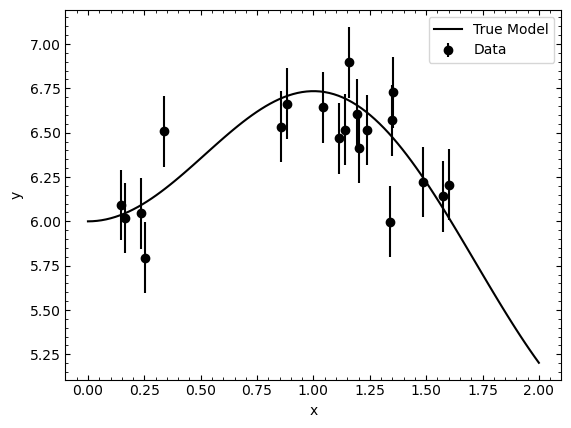

In [3]:
# A quick plot ....
xfine = np.linspace(0, 2, 100)
plt.errorbar(x, y, yerr=sigma_y, fmt='ko', label='Data')
plt.plot(xfine, ymodel(xfine, a1, a2, a3), 'k-', label='True Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(numpoints=1, loc='best');

The curve in the line above is the true curve. This is **not** be the best fit! We can use the $\chi^2$ to quantify how close the data is to the true model. You will explore this much more in the prelab. See that for more details.

In [4]:
chisq = np.sum(((y - ymodel(x, a1, a2, a3)) / sigma_y)**2)
dof = len(y) # WHY?!
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(f"""True model :
{chisq = }
{dof = }
goodness of fit = {Q}""")

True model :
chisq = 20.120119933638737
dof = 20
goodness of fit = 0.45043853313007554


Next we perform the fit using `scipy.optimize.curve_fit`. Notice that we pass in the $x$, $y$, and uncertainties, $\sigma_y$. Note that the uncertainties we pass in are **absolute uncertainties**. Roughly this means that they are "scaled correctly". This is pretty much what we always mean when we do an experiment (at least in physics), thus we need to set `absolute_sigma=True` since this is **not the default** (which surprises me). Returned is a `tuple` containing the best fit parameters in the array `p` and the covariance matrix in `C`. The square root of the diagonal elements of the covariance matrix are the fit uncertainties for the parameters.

We calculate the $\chi^2$ for the fit using the definition from above. To do this we must pass the fitted parameters to the function that defines our model. Our model has three parameters so `p` will be a three element array. In principle we would need to call it as `ymodel(x, p[0], p[1], p[2])`. Even for just three parameters that is tedious. Further, if we change the number of parameters in the model we would need to change every place we call the model function with fitted parameters. A much better approach is to just use `*p` as `ymodel(x, *p)`. This expands the array exactly as we need for passing to a function and works for any number of parameters in `p`.

In [5]:
(p, C) = opt.curve_fit(ymodel, x, y, sigma=sigma_y,
                       absolute_sigma=True)

Um, that failed! Why? As the error says, there is a problem with the shape of `sigma` which we have stored in `sigma_y`.

In [6]:
sigma_y

0.2

Notice that `sigma_y` is just a single number, but if we go back and check the documentation ... we find it needs to be an array. There are a couple of ways to fix this. The easiest is probably to make `sigma_y` and array. Notice that this will not change any of the other calculations we have (or will) do so there is nothing wrong with this. Alternatively we could just make the appropriate change when we call `curve_fit()`.

In [7]:
# Since we will call curve_fit more than once, just redefine sigma_y
# Here is yet another way of creating an array, filling it with a particular value.
sigma_y = np.full_like(y, sigma_y)
(p, C) = opt.curve_fit(ymodel, x, y, sigma=sigma_y,
                       absolute_sigma=True)
sigp = np.sqrt(np.diag(C))
chisq = np.sum(((y - ymodel(x, *p)) / sigma_y)**2)
dof = len(y) - len(p)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)

print(f"""Best fit:
a1 = {p[0]} +/- {sigp[0]}
a2 = {p[1]} +/- {sigp[1]}
a3 = {p[2]} +/- {sigp[2]}
{chisq = }
{dof = }
goodness of fit = {Q}""")

Best fit:
a1 = -109.94045904477886 +/- 0.07112699837988015
a2 = 8.207551544078726 +/- 0.06941439019670433
a3 = -118.11987013691837 +/- 0.006772723520667646
chisq = 4236.965124831054
dof = 17
goodness of fit = 0.0


A few things happened here. Notice we did not tell `curve_fit` anything about the model being fit, in particular we did not tell it the number of parameters. Yet it was able to determine there were three! Using the introspection capabilities in Python `curve_fit` can often determine how many parameters are passed to a function. It used that information to provide best fit estimates for the three parameters in our model. Except that it (probably?) did not do a very good job! The parameters are (probably) not very close to the true values, the $\chi^2$ is very large, and the goodness of fit is horrible. Let us look at this more carefully by plotting the data, the true model, and the best fit.

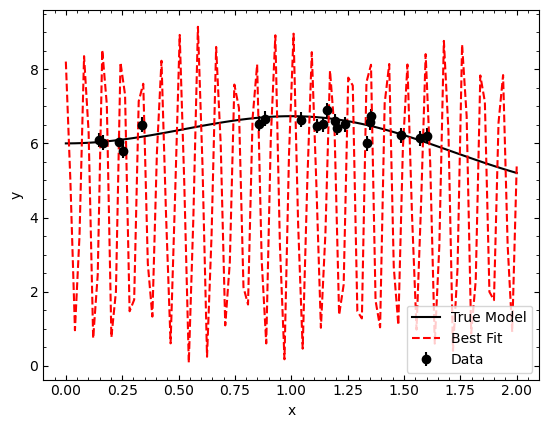

In [8]:
plt.errorbar(x, y, yerr=sigma_y, fmt='ko', label='Data')
plt.plot(xfine, ymodel(xfine, a1, a2, a3), 'k-', label='True Model')
plt.plot(xfine, ymodel(xfine, *p), 'r--', label='Best Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(numpoints=1, loc='lower right');

This should not look like a very good fit at all! What happened? Here we are performing a **non-linear fit**. Unlike linear fits, non-linear ones are sensitive to the initial guesses for the parameters. Since we did not provide initial guesses, defaults were chosen and the defaults were not very good for our model. The general problem is that finding the **global minimum** in a high dimensional space is very difficult. It is easy to get stuck in a local minimum and hard to know if there is a deeper minimum somewhere else or what direction to go to search for it. Minimization in more than one dimension thus requires a guess for where to start looking and the quality of the minimum found will depend on the quality of the initial guess.

For `curve_fit` we can provide initial guesses using the `p0` keyword. This is an array with a guess for each of the parameters. For a non-linear fit we should always provide initial guesses. How we determine what a good guess is will be problem dependent; there is no general rule. Here we know the true values so use them as a guess.

Best fit:
a1 = 1.2386247205772531 +/- 0.11337985910972637
a2 = 6.022808281047697 +/- 0.10053465162864136
a3 = 0.2284225674331817 +/- 0.02688629688265648
chisq = 17.64033882156725
dof = 17
goodness of fit = 0.41186282213367503


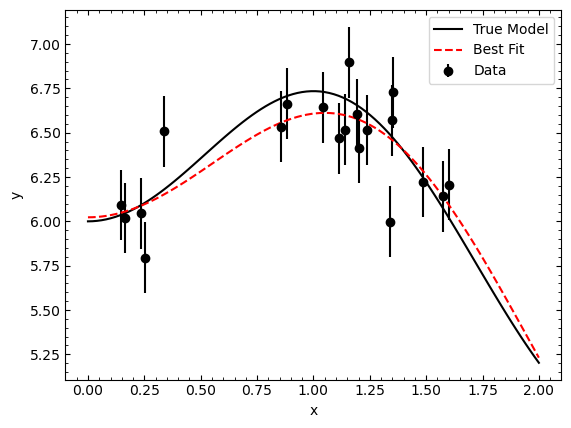

In [9]:
(p, C) = opt.curve_fit(ymodel, x, y, sigma=sigma_y,
                       p0=np.array([a1, a2, a3]),
                       absolute_sigma=True)
sigp = np.sqrt(np.diag(C))
chisq = np.sum(((y - ymodel(x, *p)) / sigma_y)**2)
dof = len(y) - len(p)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(f"""Best fit:
a1 = {p[0]} +/- {sigp[0]}
a2 = {p[1]} +/- {sigp[1]}
a3 = {p[2]} +/- {sigp[2]}
{chisq = }
{dof = }
goodness of fit = {Q}""")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x, y, yerr=sigma_y, fmt='ko', label='Data')
ax.plot(xfine, ymodel(xfine, a1, a2, a3), 'k-', label='True Model')
ax.plot(xfine, ymodel(xfine, *p), 'r--', label='Best Fit')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(numpoints=1, loc='best');

This looks much better. The parameters should now be in good agreement with the true values and the plot looks much better. Both the $\chi^2$ and the goodness of fit should be consistent with what we mean by a "good fit".

## Nonlinear or Linear?

As we saw above, a nonlinear fit is challenging: we need to know something about the expected parameters.
If we start far from the global minimum, we may not find a good minimum.
On the other hand, if we are fitting a linear problem then we can always find the global minimum "algebraically", as discussed in the lecture and as you will implement.
Thus, we always prefer a linear fit to a nonlinear one.
Sometimes a nonlinear fit can be converted to a linear fit, but are they the same?
Let us see an example.

Consider the case of measuring decays.
To make a simple model of an experiment, suppose we start with some number $N_0$ particles and that they decay with a lifetime $\tau$.
We measure the number of particles at times $t_j$.
This will give us a number of surviving particles in some time intervals.
The count in each bin follows a Poisson distribution.
This is a long way of saying that the number of particles follows
$$ N(t) = N_0 \mathrm{e}^{-t / \tau}. $$

We will represent the expected number of counts as the value at the central time, $t_j$.
(In practice we should integrate over the width of the interval between measurements to get the expected number.
If the bins are narrow enough, $(t_{j+1} - t_{j})/\tau \ll 1$, this is irrelevant.)
Thus, given $N_0$, $\tau$, and some choices times, we can model an experiment by randomly generating data from a Poisson distribution.
(We will talk more about random numbers the last week of class.)

Finally, to make this more realistic, we will include the fact that you (I mean the experimenter) overslept and thus did not take data immediately at "$t=0$", i.e., the time at which $N_0$ was known.
We will thus "extrapolate" to $t=0$ to find $N_0$.

For data that is counts, i.e., "counting statistics", we typically approximate the uncertainty as Gaussian with variance given by the square root of the number of counts measured.
Here we generate some random data and see what it looks like.

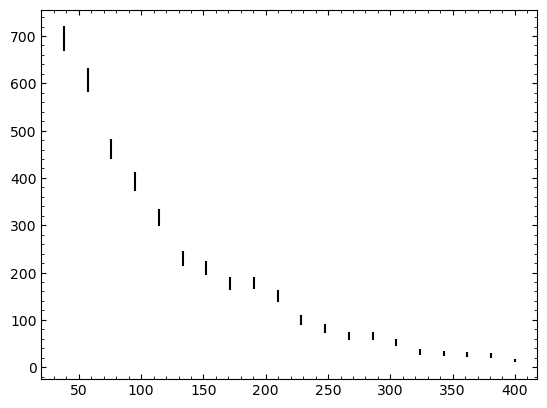

In [10]:
# The decay curve
def decay(t, N0, tau):
    return N0*np.exp(-t/tau)
    
# Some arbitrary parameters
N0 = 1000
tau = 100

# Some arbitrary time bins
Nbins = 22
t = np.linspace(0, 4*tau, Nbins)[2:]

# Generate the data with noise
nt = rng.poisson(decay(t, N0, tau), size=len(t))
# Uncertainty
sigma_nt = np.sqrt(nt)
# A quick plot of our data.
# Notice we can get just error bars, not points and/or lines, with fmt="none".
# We will not do this in our plots below, we will want to also see the measured value.
plt.errorbar(t, nt, yerr=sigma_nt, fmt='none', color='k');

Our model is nonlinear *in the parameters*.
In particular, $\tau$ appears in a nonlinear manner in the decay.
Thus we need to perform a nonlinear fit for our two parameters.
In this case we can use the known values as our guess (this better be sufficiently close to the global minimum in $\chi^2$ to give us a good result).
In practice we would need some way to estimate the starting values.
(As we will see below, in this case there are ways of doing this.)

Performing the fit and plotting the results we find the following.

Best fit:
N0 = 1024.5595806539789 +/- 29.31449884725426
tau = 98.70892846194653 +/- 1.9335350248089604
chisqnl = 23.752395698057608
dofnl = 18
goodness of fit = 0.16330821723046882


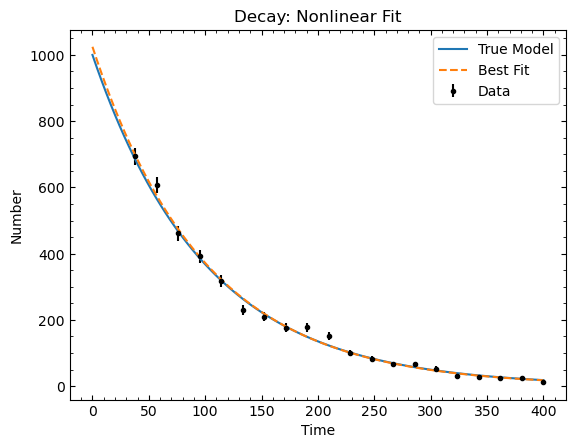

In [11]:
(pnl, Cnl) = opt.curve_fit(decay, t, nt, sigma=sigma_nt,
                           p0=np.array([N0, tau]), absolute_sigma=True)
sigpnl = np.sqrt(np.diag(Cnl))
chisqnl = np.sum(((nt - decay(t, *pnl)) / sigma_nt)**2)
dofnl = len(nt) - len(pnl)
Qnl = sf.gammaincc(0.5*dofnl, 0.5*chisqnl)
print(f"""Best fit:
N0 = {pnl[0]} +/- {sigpnl[0]}
tau = {pnl[1]} +/- {sigpnl[1]}
{chisqnl = }
{dofnl = }
goodness of fit = {Qnl}""")

tfine = np.linspace(0, t[-1], 100)
fig = plt.figure()
ax = fig.add_subplot(111)
# Without changing size by hand, '.' is the smallest marker
ax.errorbar(t, nt, yerr=sigma_nt, fmt='.', color='k', label='Data')
ax.plot(tfine, decay(tfine, N0, tau), '-', label='True Model')
ax.plot(tfine, decay(tfine, *pnl), '--', label='Best Fit')
ax.set_xlabel('Time')
ax.set_ylabel('Number')
ax.set_title('Decay: Nonlinear Fit')
ax.legend(numpoints=1, loc='best');

By eye the fit should look very good.
The $\chi^2$ and goodness of fit should verify this.
The best fit values for $N_0$ and $\tau$ should be close to the values we used to construct the data.
What does close mean?
We have the uncertainties in these parameters.
We expect about 68.5% of the time the values will be within $1\sigma$, *etc*.

The "by eye" comparison is a bit difficult since the number is changing by orders of magnitude and getting close to zero.
Thus it can be hard to see how close the curves are to the data.
How many of the error bars are intersecting by the curves?
For the later times we do not even see the error bars, they are smaller than size of the marker used.
To help with this we can produce a semilog plot.

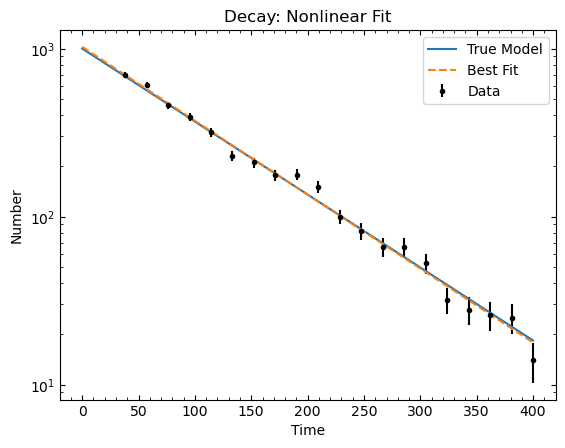

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(t, nt, yerr=sigma_nt, fmt='.', color='k', label='Data')
ax.semilogy(tfine, decay(tfine, N0, tau), '-', label='True Model')
ax.plot(tfine, decay(tfine, *pnl), '--', label='Best Fit')
ax.set_xlabel('Time')
ax.set_ylabel('Number')
ax.set_title('Decay: Nonlinear Fit')
ax.legend(numpoints=1, loc='best');

We see this is easier to read over the entire time range, though now the error bars are small at the earliest times.
We also see that, relative to their value, the error bars at late times, where the numbers of particles is small, are large.
In other words, the signal-to-noise is larger than at early times.
The signal-to-noise is, literally, the signal divided by the noise.
Here we have $N$ counts with noise $\sqrt{N}$, so the signal to noise is $\sqrt{N}$.

This also shows the obvious fact (obvious at least after looking at this plot) that the logarithm of the number of particles is a linear function of time.
Thus, we could fit the logarithm of the number to a line!

### Linear Fit

Notice that
$$ y(t) \equiv \ln(N(t)) = -\frac{t}{\tau} + \ln(N_0) \equiv -\alpha t + \beta, $$
for
$$ \alpha \equiv \frac{1}{\tau}, \quad \beta \equiv \ln(N_0). $$
This is a linear fit!
Once we fit for $\alpha$ and $\beta$ we can compute
$$ \tau = \frac{1}{\alpha}, \quad N_0 = \mathrm{e}^{\beta}. $$

We also know about the uncertainties.
For Gaussian uncertainties, if $a = f(\vec{b})$ and we know the uncertainties $\sigma_{b_i}$, then the propagation of errors tells us
$$ \sigma_a^2 = \sum_i \left( \frac{\partial f}{\partial b_i} \right)^2 \sigma_{b_i}^2. $$
With this
$$ \sigma_y = \frac{\sigma_N}{N}, \quad \sigma_\tau = \frac{\sigma_\alpha}{\alpha^2} = \tau^2 \sigma_\alpha, \quad \sigma_{N_0} = \mathrm{e}^{\beta} \sigma_\beta = N_0 \sigma_\beta. $$

We can now transform our original data and use it in a linear fit for the slope and intercept, $\alpha$ and $\beta$.

Best fit:
alpha = 0.010015315459908965 +/- 0.00019760417864665434
beta  = 6.927392408358405 +/- 0.028583577381680148
chisql = 24.413942944932423
dofl = 18
goodness of fit = 0.1419286245541449


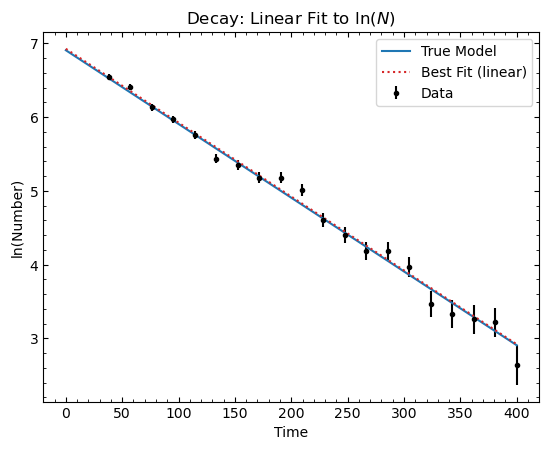

In [13]:
def linear(t, alpha, beta):
    return -alpha * t + beta
    
y = np.log(nt)
sigma_y = sigma_nt / nt
(pl, Cl) = opt.curve_fit(linear, t, y, sigma=sigma_y,
                         absolute_sigma=True)
sigpl = np.sqrt(np.diag(Cl))
chisql = np.sum(((y - linear(t, *pl)) / sigma_y)**2)
dofl = len(y) - len(pl)
Ql = sf.gammaincc(0.5*dofl, 0.5*chisql)
print(f"""Best fit:
alpha = {pl[0]} +/- {sigpl[0]}
beta  = {pl[1]} +/- {sigpl[1]}
{chisql = }
{dofl = }
goodness of fit = {Ql}""")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(t, y, yerr=sigma_y, fmt='.', color='k', label='Data')
ax.plot(tfine, np.log(decay(tfine, N0, tau)), '-', label='True Model')
ax.plot(tfine, linear(tfine, *pl), 'C3:', label='Best Fit (linear)')
ax.set_xlabel('Time')
ax.set_ylabel('ln(Number)')
ax.set_title(r'Decay: Linear Fit to $\ln(N)$')
ax.legend(numpoints=1, loc='best');

We can convert the linear parameters back to the decay parameters as noted above.

Using these parameters we can also calculate the $\chi^2$, *etc*.

In [14]:
ppl = np.array([np.exp(pl[1]), 1 / pl[0]])
sigppl = np.array([ppl[0] * sigpl[1], ppl[1]**2 * sigpl[0]])
chisqlnl = np.sum(((nt - decay(t, *ppl)) / sigma_nt)**2)
doflnl = len(nt) - len(ppl)
Qlnl = sf.gammaincc(0.5*doflnl, 0.5*chisqlnl)
print(f"""Best fit:
N0  = {ppl[0]} +/- {sigppl[0]}
tau = {ppl[1]} +/- {sigppl[1]}
{chisqlnl = }
{doflnl = }
goodness of fit = {Qlnl}""")

Best fit:
N0  = 1019.8312060895959 +/- 29.15042419551416
tau = 99.84707960552743 +/- 1.9700028655809005
chisqlnl = 24.434555800812213
doflnl = 18
goodness of fit = 0.14130019116965165


Finally, we can plot the nonlinear fit and the transformed linear fit on a semilog plot to compare the two curves.

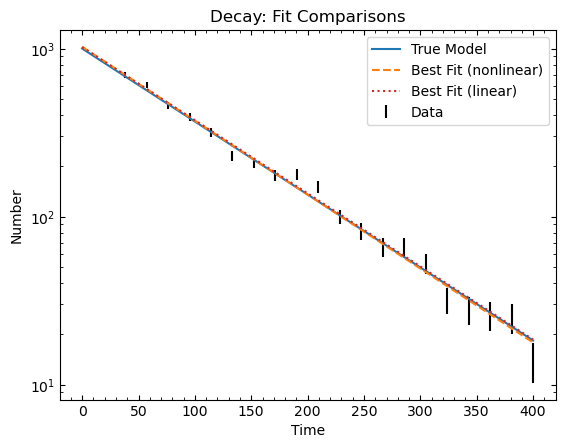

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(t, nt, yerr=sigma_nt, fmt='none', color='k', label='Data')
ax.semilogy(tfine, decay(tfine, N0, tau), '-', label='True Model')
ax.plot(tfine, decay(tfine, *pnl), '--', label='Best Fit (nonlinear)')
ax.plot(tfine, decay(tfine, *ppl), 'C3:', label='Best Fit (linear)')
ax.set_xlabel('Time')
ax.set_ylabel('Number')
ax.set_title('Decay: Fit Comparisons')
ax.legend(numpoints=1, loc='best');

We see they are very similar, but there are differences.
To highlight these differences we plot the residuals in the data against the difference in the two fits.
In other words, we subtract the data from the model and the nonlinear fit curve from the (converted) linear fit curve.

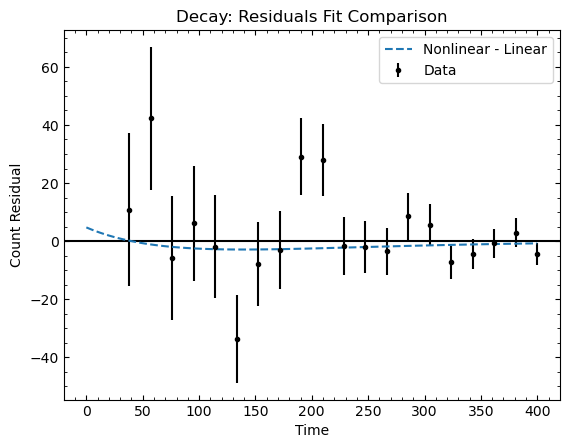

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(0, color='k')
ax.errorbar(t, nt - decay(t, N0, tau), yerr=sigma_nt, fmt='.', color='k', label='Data')
ax.plot(tfine, decay(tfine, *pnl) - decay(tfine, *ppl), '--', label='Nonlinear - Linear')
ax.set_xlabel('Time')
ax.set_ylabel('Count Residual')
ax.set_title('Decay: Residuals Fit Comparison')
ax.legend(numpoints=1, loc='best');

### Why are they different?

We found that a nonlinear fit and a linear fit *do not produce the same results*.
Sure, they are close, but they are not the same.

Even more so, if we convert the linear fit parameters back to the nonlinear model parameters, they are not identical to the nonlinear fit but also the $\chi^2$ and goodness of fit are not identical to the linear fit values!
Why not?

Recall that when using the $\chi^2$ for fitting we are **assuming all uncertainties are Gaussian**.
Is this true?
Notice that we are treating the count uncertainties as Gaussian.
But really the follow a Poisson distribution.
We are *also* treating the log of the counts as having Gaussian uncertainties.
Is this true?
We can check!
Here we will do some of the possible checks.

Here we will compare samples from the Poisson distribution to that of a Gaussian.
We will also compare the logarithm of these samples to a Gaussian.
The central limit theorem tells us that (almost) every probability distribution near its peak looks Gaussian.
Thus, for sufficiently large number of counts we expect the Gaussian **approximation** we are using is good.
This is why our results above were in good agreement, but not identical.

As we see by changing the mean number of counts that the validity of the approximations depend on the number of counts.

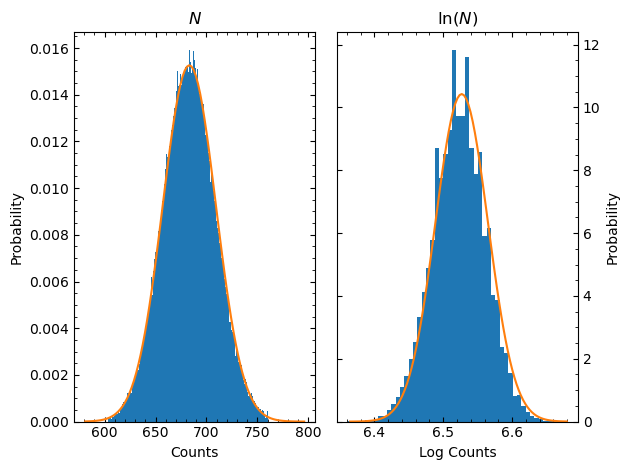

In [44]:
def gauss(x, mu, sigma):
    return np.exp(-((x - mu)**2 / 2 / sigma**2)) / np.sqrt(2 * np.pi) / sigma
                  
Nsample = 100_000
Nlogbins = 50

mu = decay(t[0], N0, tau)
#mu = decay(t[-1], N0, tau)
sigma = np.sqrt(mu)
nt0 = rng.poisson(mu, size=Nsample)

fig = plt.figure()

nx = np.linspace(nt0.min(), nt0.max(), 100)
ax = fig.add_subplot(121)
g = gauss(nx, mu, sigma)
# Bins in steps of 1
linbins = np.arange(int(mu - 3*sigma), int(mu + 3*sigma)+1)
ax.hist(nt0, bins=linbins, density=True, align='left')
ax.plot(nx, g)
ax.set_title('$N$')
ax.set_xlabel('Counts')
ax.set_ylabel('Probability')

lmu = np.log(mu)
lsigma = sigma / mu
lnt0 = np.log(nt0)
lnx = np.linspace(lnt0.min(), lnt0.max(), 100)
lax = fig.add_subplot(122)
lg = gauss(lnx, lmu, lsigma)
lax.hist(lnt0, bins=Nlogbins, density=True, align='left')
lax.plot(lnx, lg)
lax.yaxis.set_label_position('right')
lax.yaxis.set_ticks_position('right')
lax.yaxis.set_tick_params(left=True)
lax.set_title(r'$\ln(N)$')
lax.set_xlabel('Log Counts')
lax.set_ylabel('Probability')
fig.tight_layout()